# Prediction
Es werden verschiedene Modelle getestet und visualisiert.

In [2]:
import pandas as pd
import numpy as np
import pickle
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model, ensemble, tree
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('df_preprocessed.pickle', 'rb') as fp:
    df = pickle.load(fp)
df.head()

,Datum,Wochentag,Fahrweg,Fahrt,Fahrzeugnummer,Linienverlauf,SollAb,IstAb,GPS-Breite Soll,GPS-Länge Soll,...,Linienverlauf_51 Hansestr. A,Linienverlauf_52 Raringheide,Linienverlauf_53 Pater-Kolbe-Str.,Linienverlauf_54 Plutoweg,Linienverlauf_55 Amelsb¿ren Schule,Linienverlauf_56 Amelsb¿ren Kirche,Linienverlauf_57 Davertstr. B,Linienverlauf_58 Am Dornbusch,Haltestelle,month
0,2016-10-10,Montag,4,1061896,1299,01 Roxel Hallenbad A,2016-10-10 05:16:00,2016-10-10 05:15:45,519544255.0,75273611.0,...,0,0,0,0,0,0,0,0,1,10
1,2016-10-10,Montag,2,1081890,5556,30 Ludgeriplatz B,2016-10-10 05:17:00,2016-10-10 05:17:58,519558997.0,76278508.0,...,0,0,0,0,0,0,0,0,30,10
2,2016-10-10,Montag,4,1061896,1299,02 Pantaleonstra¿e,2016-10-10 05:17:00,2016-10-10 05:17:14,519539.0,75313352.0,...,0,0,0,0,0,0,0,0,2,10
3,2016-10-10,Montag,2,1081890,5556,31 Goebenstr.,2016-10-10 05:19:00,2016-10-10 05:19:03,51952888.0,76254844.0,...,0,0,0,0,0,0,0,0,31,10
4,2016-10-10,Montag,4,1061896,1299,03 Pienersallee,2016-10-10 05:19:00,2016-10-10 05:19:09,519511969.0,75300852.0,...,0,0,0,0,0,0,0,0,3,10


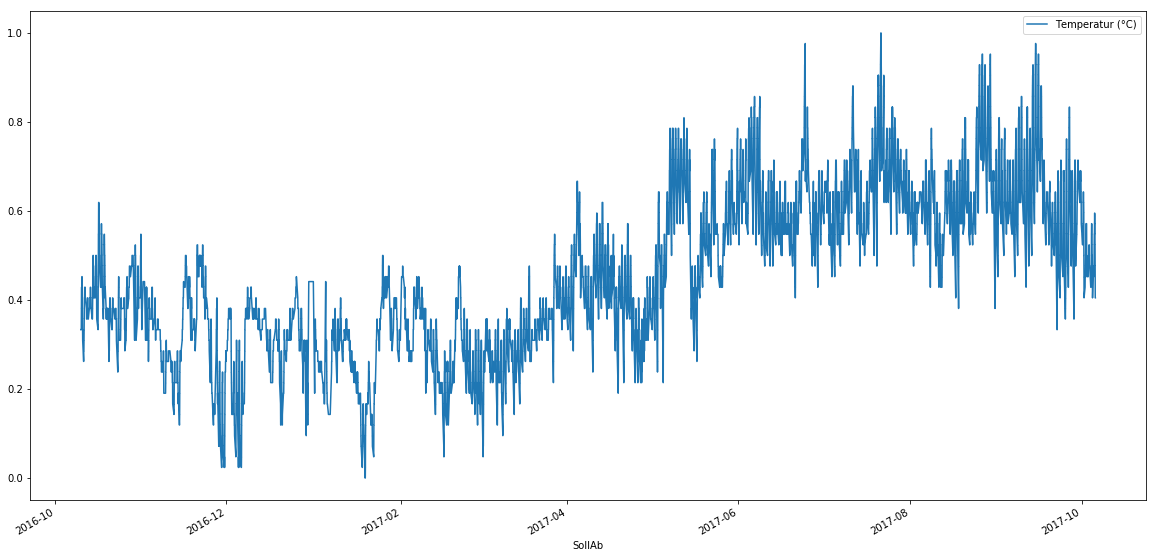

In [3]:
# Take a look at the preprocessed data
df.plot(x='SollAb', y='Temperatur (°C)', figsize=(20, 10))

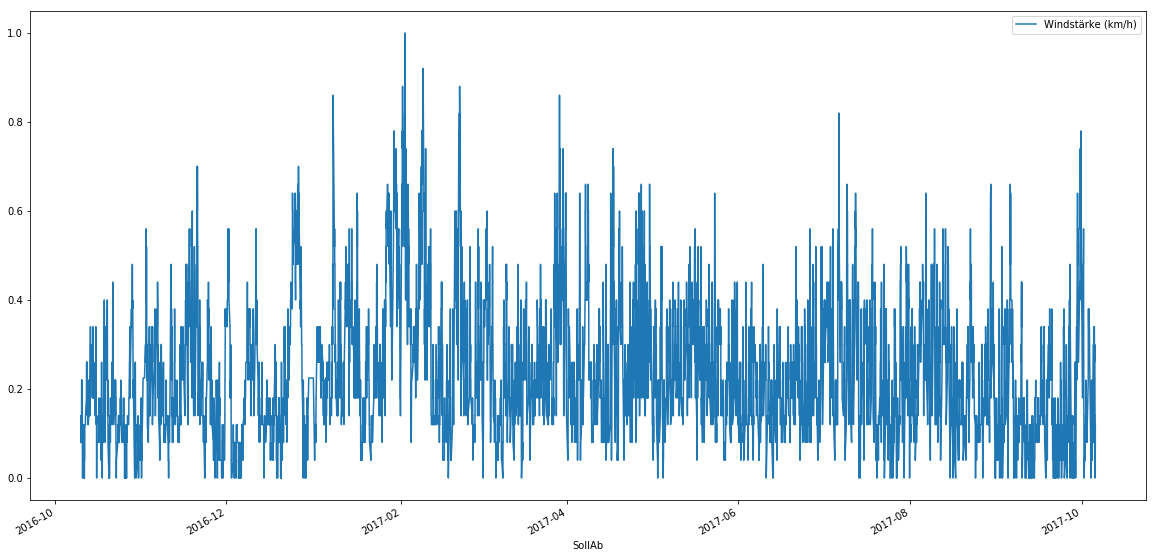

In [4]:
df.plot(x='SollAb', y='Windstärke (km/h)', figsize=(20, 10))

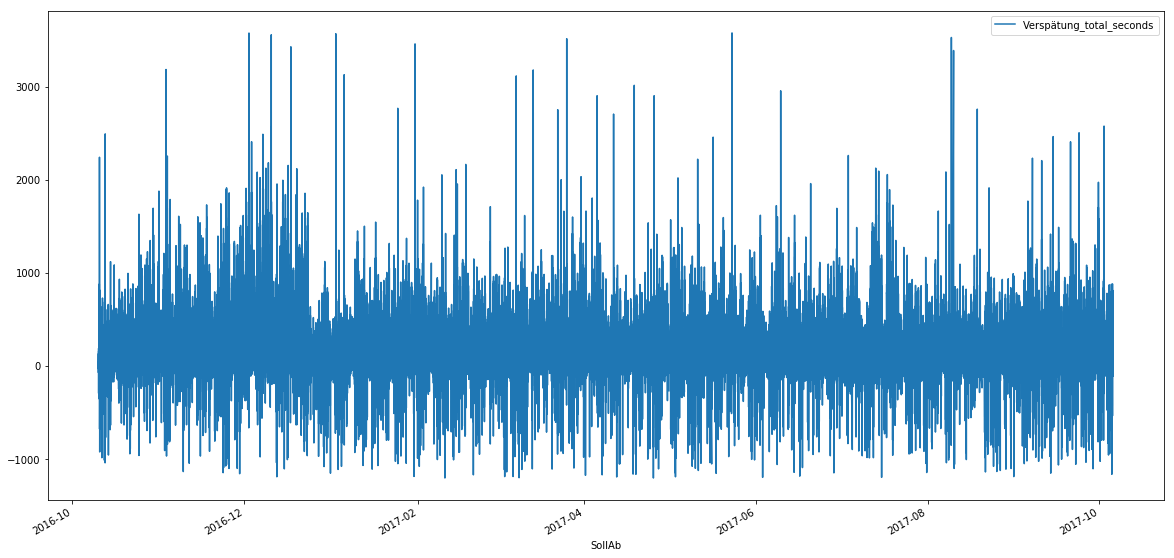

In [4]:
df.plot(x='SollAb', y='Verspätung_total_seconds', figsize=(20, 10))

In [6]:
# Exclude single drives to test on for later.
df_one_drive1 = df[(df["Datum"] == "2017-03-10") & (df["Fahrt"] == 1022034)]
df_one_drive2 = df[(df["Datum"] == "2017-07-21") & (df["Fahrt"] == 1223066)]
df_one_drive3 = df[(df["Datum"] == "2016-11-27") & (df["Fahrt"] == 1367074)]

In [7]:
# Split into training and test set (1:10).
df_test = df.iloc[::10]
df_train = df.iloc[~df.index.isin(df_test.index)]
# Remove drives from training set.
df_train = df_train.iloc[~(df_train.index.isin(df_one_drive1.index)
                          | df_train.index.isin(df_one_drive2.index)
                          | df_train.index.isin(df_one_drive3.index))]
df_train.shape, df_test.shape

((765237, 92), (85045, 92))

In [8]:
# Separate data into features and target.
feature_cols = [col_name for col_name in df 
                if col_name.startswith('Wetter_') 
                or col_name.startswith('Wochentag_')
                or col_name.startswith('Linienverlauf_')]
feature_cols.extend(['Temperatur (°C)', 'Windstärke (km/h)', 'Feiertag', 'month', 'Haltestelle'])
features = df_train[feature_cols]
target = df_train['Verspätung_total_seconds']

df_train[feature_cols].head()

,Wochentag_Dienstag,Wochentag_Donnerstag,Wochentag_Freitag,Wochentag_Mittwoch,Wochentag_Montag,Wochentag_Samstag,Wochentag_Sonntag,Wetter_Gewitter,Wetter_Klarer Himmel,Wetter_Nebel,...,Linienverlauf_54 Plutoweg,Linienverlauf_55 Amelsb¿ren Schule,Linienverlauf_56 Amelsb¿ren Kirche,Linienverlauf_57 Davertstr. B,Linienverlauf_58 Am Dornbusch,Temperatur (°C),Windstärke (km/h),Feiertag,month,Haltestelle
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,30
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,2
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,31
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,3
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.333333,0.14,False,10,32


In [9]:
# Try out different models
def try_model(model):
    """Run a model on the data. 
    
    Compute the mean absolute difference and the R2 score."""
    model.fit(features, target)
    predictions = model.predict(df_test[feature_cols])
    loss = np.mean(np.abs((df_test['Verspätung_total_seconds'] - predictions)))
    print('loss = ', loss)
    print('score = ', metrics.r2_score(df_test['Verspätung_total_seconds'], predictions))
    
    return model

In [10]:
mdummy = try_model(DummyRegressor())

loss =  141.50149296
score =  -1.78829326749e-05


In [11]:
m0 = try_model(linear_model.LinearRegression())

loss =  128.092105935
score =  0.12898413748


In [12]:
m1 = try_model(linear_model.ElasticNetCV())

loss =  134.728921554
score =  0.0444974037121


In [13]:
m2 = try_model(linear_model.ElasticNet())

loss =  133.743583135
score =  0.0557015198346


In [14]:
m3 = try_model(ensemble.RandomForestRegressor(n_estimators=10))

loss =  118.321205084
score =  0.228696000243


In [12]:
m4 = try_model(ensemble.RandomForestRegressor(n_estimators=20))

loss =  118.034398566
score =  0.23040765716


In [10]:
# This is just for visualization.
m5 = try_model(tree.DecisionTreeRegressor(max_depth=2))
tree.export_graphviz(m5, out_file='tree.dot')

loss =  131.554865357
score =  0.0932344760666


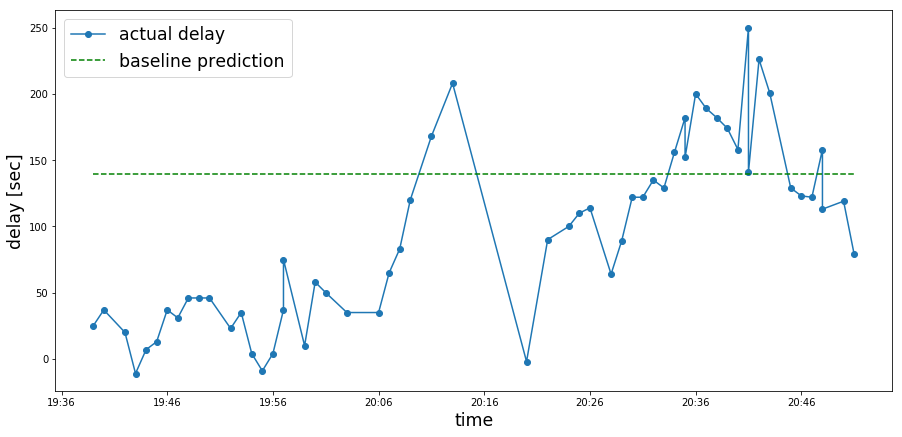

In [18]:
%matplotlib inline
import matplotlib.dates as md


def plot_comparison(model, drive, label, format_str):
    # Predict the reserved drive.
    prediction = model.predict(drive[feature_cols])
    plt.figure(figsize=(15, 7))
    plt.plot(drive["SollAb"], drive['Verspätung_total_seconds'], '-o', label="actual delay")
    plt.plot(drive["SollAb"], prediction, format_str,label=label + ' prediction')
    xfmt = md.DateFormatter('%H:%M')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(xfmt)
    plt.xlabel('time', fontsize='xx-large')
    plt.ylabel('delay [sec]', fontsize='xx-large')
    plt.legend(loc='upper left', fontsize='xx-large')
    plt.savefig(label + '.png', dpi=600)

plot_comparison(mdummy, df_one_drive3, 'baseline', 'g--')

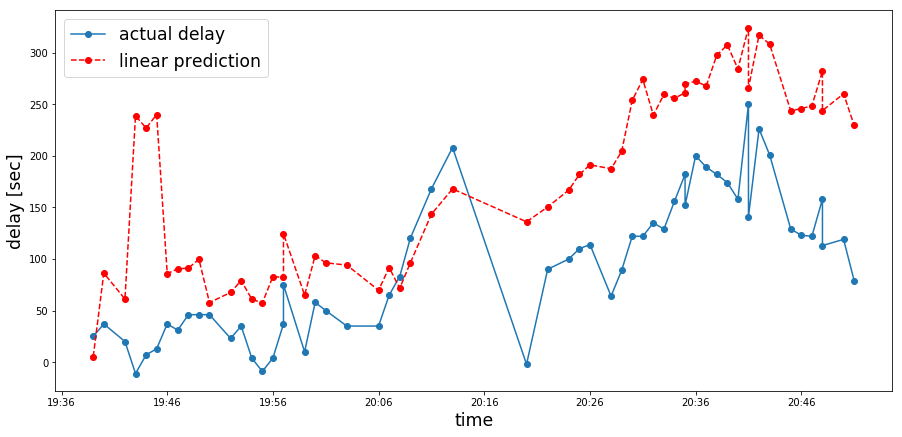

In [19]:
plot_comparison(m0, df_one_drive3, 'linear', 'ro--')

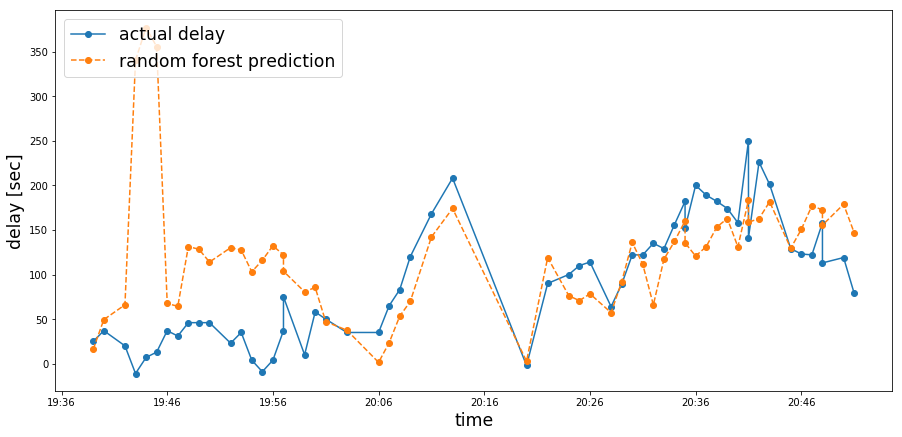

In [20]:
plot_comparison(m4, df_one_drive3, 'random forest', 'o--')

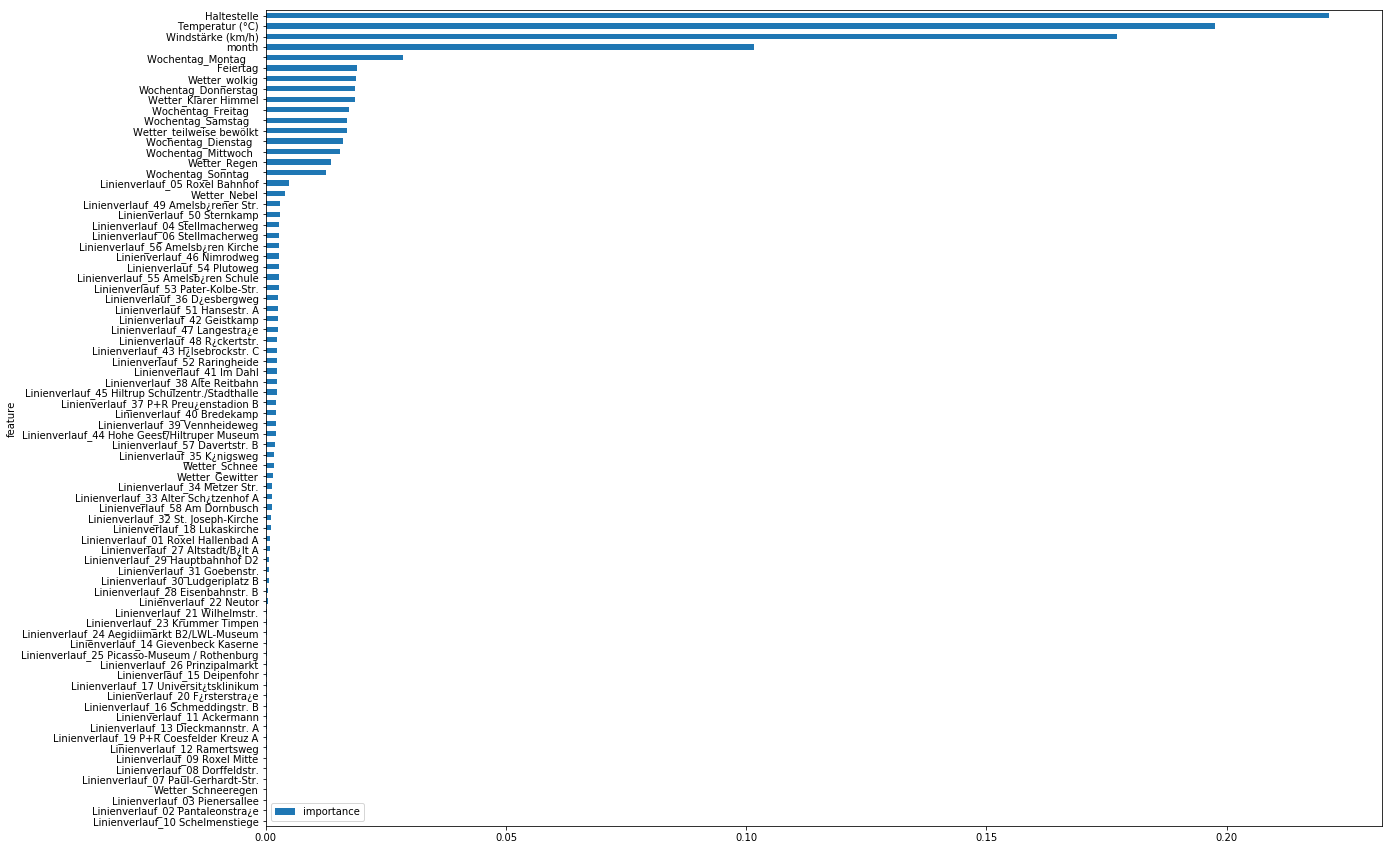

In [13]:
# Evaluating feature importance
feature_importance = pd.DataFrame(data=m4.feature_importances_[None, :], columns=feature_cols)
feature_importance = feature_importance.melt(var_name='feature', value_name='importance')
feature_importance = feature_importance.sort_values(by='importance')
feature_importance.plot.barh(x='feature', figsize=(20, 15))


In [22]:
# Export the training data to CSV.
df[[*feature_cols, 'Verspätung_total_seconds']].to_csv('busdata.csv', index=False)